# Lab8: Text classification

In [1]:
! pip install fasttext
! pip install ktrain
! pip install shap
! pip3 install --upgrade tensorflow-gpu

     |████████████████████████████████| 71kB 2.6MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3039078 sha256=9ed51a0474b253fb153024bf70f55147d8fd1b4aaabe2fb9e35e2c90d6d05ab9
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
     |████████████████████████████████| 25.3MB 186kB/s 
     |████████████████████████████████| 983kB 50.3MB/s 
     |████████████████████████████████| 266kB 47.5MB/s 
     |████████████████████████████████| 1.3MB 56.7MB/s 
     |████████████████████████████████| 1.1MB 56.9MB/s 
     |████████████████████████████████| 471kB 52.3MB/s 
     |████████████████████████████████| 890kB 32.6MB/s 
     |████████████████████████████████| 2.9MB 33.4MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.2-cp36-none-any.whl size=25276305 sha256=7ba263521a26923419368a6f07dd43d08881087ee5d50ba1cc6b1d4a2127154e
  Stored in directory: /root/.cache/pip/w

In [2]:
import fasttext
import ktrain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
print(tf.__version__)

2.4.0


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_DIR = '/content/drive/MyDrive/studia/sem9/PJN'

In [6]:
tag_files = {
    'task_1': {
        'train': f'{DATA_DIR}/task_6-1/training_set_clean_only_tags.txt', 
        'test': f'{DATA_DIR}/Task6/task 01/test_set_clean_only_tags.txt',
    },
    'task_2': {
        'train': f'{DATA_DIR}/task_6-2/training_set_clean_only_tags.txt',
        'test': f'{DATA_DIR}/Task6/task 02/test_set_only_tags.txt',
    },
}

text_files = {
    'task_1': {
        'train': f'{DATA_DIR}/task_6-1/training_set_clean_only_text.txt', 
        'test': f'{DATA_DIR}/Task6/task 01/test_set_clean_only_text.txt',
    },
    'task_2': {
        'train': f'{DATA_DIR}/task_6-2/training_set_clean_only_text.txt',
        'test': f'{DATA_DIR}/Task6/task 02/test_set_only_text.txt',
    },
}

## Get acquainted with the data of the Polish Cyberbullying detection dataset. Pay special attention to the distribution of the positive and negative examples in the first task as well as distribution of the classes in the second task.

In [7]:
def read_lines(path):
    with open(path) as file:
        return file.readlines()

### Surowe dane

Dane z podanych plików zostały wczytane i sparsowane do DataFrame'ów. Rozkład klas został przedstawiony na histogramie.

#### Task 1

##### Train

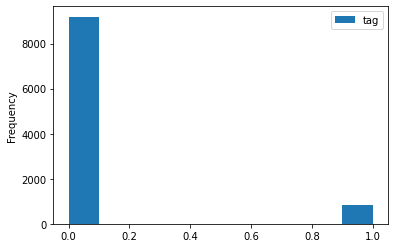

In [8]:
task_1_train = pd.DataFrame({
    'text': [line.strip() for line in read_lines(text_files['task_1']['train'])],
    'tag': [int(line.strip()) for line in read_lines(tag_files['task_1']['train'])],
})

task_1_train.plot.hist('tag')

##### Test

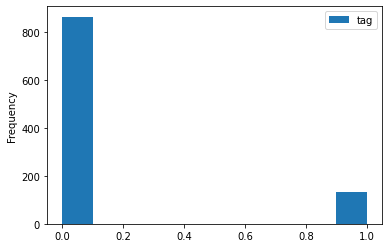

In [9]:
task_1_test = pd.DataFrame({
    'text': [line.strip() for line in read_lines(text_files['task_1']['test'])],
    'tag': [int(line.strip()) for line in read_lines(tag_files['task_1']['test'])],
})

task_1_test.plot.hist('tag')

#### Task 2

##### Train

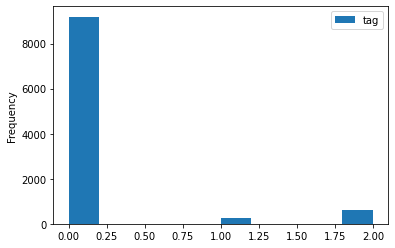

In [10]:
task_2_train = pd.DataFrame({
    'text': [line.strip() for line in read_lines(text_files['task_2']['train'])],
    'tag': [int(line.strip()) for line in read_lines(tag_files['task_2']['train'])],
})

task_2_train.plot.hist('tag')

##### Test

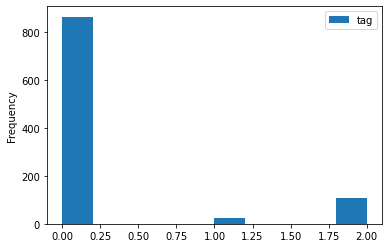

In [11]:
task_2_test = pd.DataFrame({
    'text': [line.strip() for line in read_lines(text_files['task_2']['test'])],
    'tag': [int(line.strip()) for line in read_lines(tag_files['task_2']['test'])],
})

task_2_test.plot.hist('tag')

### Oversampling zbiorów testowych

W związku z bardzo nierównomiernym rozkładem klas w zbiorze treningowym wykonany został _oversampling_.




In [12]:
# inspiration: https://stackoverflow.com/a/48373329

def balance_classes(data):
    max_size = data['tag'].value_counts().max()
    data_list = [data]
    for class_index, group in data.groupby('tag'):
        data_list.append(group.sample(max_size - len(group), replace=True))
    data = pd.concat(data_list).sample(frac=1)
    data.reset_index(drop=True)
    return data

#### Task 1

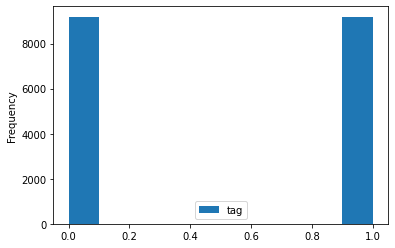

In [13]:
task_1_train = balance_classes(task_1_train)
task_1_train.plot.hist('tag')

#### Task 2

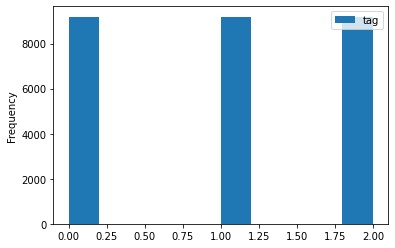

In [14]:
task_2_train = balance_classes(task_2_train)
task_2_train.plot.hist('tag')

## Train the following classifiers on the training sets (for the task 1 and the task 2):


### Bayesian classifier with TF * IDF weighting.

Do realizacji zadania wykorzystany został [`Tfid Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) oraz [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) z biblioteki `scikit-learn`.

In [15]:
def fit_tfidf_classifier(train, test):    
    vectorizer = TfidfVectorizer()
    vectorizer.fit((train['text'] + test['text']).values.astype('U'))
    
    X_train = vectorizer.transform(train['text']).toarray()
    X_train = pd.DataFrame(X_train, columns=vectorizer.get_feature_names())

    Y_train = train['tag']

    classifier = MultinomialNB()
    classifier.fit(X_train, Y_train)
    
    return vectorizer, classifier

#### Task 1

In [16]:
task_1_tfidf_vectorizer, task_1_tfidf_classifier = fit_tfidf_classifier(
    task_1_train,
    task_1_test
)

#### Task 2

In [17]:
task_2_tfidf_vectorizer, task_2_tfidf_classifier = fit_tfidf_classifier(
    task_2_train,
    task_2_test
)

### Fasttext text classifier

W pierwszej kolejności konieczne było odpowiednie przygotowanie danych.

#### Przygotowanie danych

In [18]:
def prepare_train_data_for_fast_text(train_data, output_path):
    with open(output_path, 'w+') as file:
        for _, row in train_data.iterrows():
            label = row['tag']
            data = row['text'].replace('\n', ' ')
            file.write(f'__label__{label} {data}')
            file.write('\n')

##### Task 1

In [19]:
prepare_train_data_for_fast_text(task_1_train, f'{DATA_DIR}/fast_text_task_1_train.txt')

In [20]:
! head -n 5 $DATA_DIR/fast_text_task_1_train.txt

__label__1 Ahaha, pojebanie mózgowe tego jebniętego narodu \"godność Polaków\" i 500+, zrobiło z nas szmaty
__label__1 @anonymized_account @anonymized_account Ty kurwa @anonymized_account nie pierdol w tv bo sie żygać chce
__label__0 @anonymized_account @anonymized_account Nie no, nie ma 😁 Kończymy, fakt.\nhttps://t.co/9PMxwN1XeV
__label__1 @anonymized_account @anonymized_account @anonymized_account Ty pieprzony kłamco za państwowe pieniądze.
__label__1 RT @anonymized_account @anonymized_account Twoje zachowanie i POglądy mają wiele wspólnego z komuchami.


In [21]:
print(len(task_1_train))
! wc -l $DATA_DIR/fast_text_task_1_train.txt

18380
18380 /content/drive/MyDrive/studia/sem9/PJN/fast_text_task_1_train.txt


##### Task 2

In [22]:
prepare_train_data_for_fast_text(task_2_train, f'{DATA_DIR}/fast_text_task_2_train.txt')

In [23]:
! head -n 5 $DATA_DIR/fast_text_task_2_train.txt

__label__0 @anonymized_account @anonymized_account Nic nie wiesz kobieto o Wielkiej Brytanii i nie wypowiadaj się na nieznane ci tematy.
__label__0 @anonymized_account Andrew ja myślał że Ty uciekasz z nc+ bo szukasz normalności a ty uciekasz chyba bo tam normalnie było;-)
__label__0 @anonymized_account Wiemy za to że jest @anonymized_account parchy do parchów
__label__0 @anonymized_account \"Porzucenie ulotności opiłków szczęścia\". 🙈
__label__0 @anonymized_account Dobrze choć, że sowite odszkodowania były @anonymized_account


In [24]:
print(len(task_2_train))
! wc -l $DATA_DIR/fast_text_task_2_train.txt

27570
27570 /content/drive/MyDrive/studia/sem9/PJN/fast_text_task_2_train.txt


#### Tworzenie klasyfikatora

Do realizacji zadania została wykorzystana biblioteka [`fastText`](https://fasttext.cc/docs/en/python-module.html).

##### Task 1

In [25]:
task_1_fast_text_classifier = fasttext.train_supervised(input=f'{DATA_DIR}/fast_text_task_1_train.txt')

##### Task 2

In [26]:
task_2_fast_text_classifier = fasttext.train_supervised(input=f'{DATA_DIR}/fast_text_task_2_train.txt')

### Transformer classifier (take into account that a number of experiments should be performed for this model).

Do realizacji zadania wykorzystana została biblioteka [`ktrain`](https://github.com/amaiya/ktrain). Ze względu na duży czas trwania uczenia liczba epok została znacząco ograniczona.

In [27]:
def fit_transformer_classifier(train, epochs, model_name='bert-base-uncased'):
    X_train, X_val, y_train, y_val = train_test_split(
        train['text'].values, 
        train['tag'].values,
        random_state=13
    )
    
    transformer = ktrain.text.Transformer(
        model_name, 
        maxlen=500,
        class_names=list(set(train['tag']))
    )
    
    preprocessed_train = transformer.preprocess_train(X_train, y_train)
    preprocessed_val = transformer.preprocess_test(X_val, y_val)
    
    classifier = transformer.get_classifier()
    learner = ktrain.get_learner(
        classifier,
        train_data=preprocessed_train,
        val_data=preprocessed_val,
        batch_size=6
    )
    learner.fit_onecycle(5e-5, epochs)
    
    return transformer, classifier, learner

#### Task 1

In [59]:
task_1_transformer = fit_transformer_classifier(task_1_train, 4)
task_1_transformer, task_1_transformer_classifier, task_1_transformer_learner = task_1_transformer

preprocessing train...
language: pl
train sequence lengths:
	mean : 13
	95percentile : 21
	99percentile : 23


Is Multi-Label? False
preprocessing test...
language: pl
test sequence lengths:
	mean : 13
	95percentile : 20
	99percentile : 23




begin training using onecycle policy with max lr of 5e-05...
Epoch 1/4
2298/2298 [==============================] - 1759s 759ms/step - loss: 0.6040 - accuracy: 0.6544 - val_loss: 0.2392 - val_accuracy: 0.9149
Epoch 2/4
2298/2298 [==============================] - 1740s 756ms/step - loss: 0.2216 - accuracy: 0.9142 - val_loss: 0.1422 - val_accuracy: 0.9469
Epoch 3/4
2298/2298 [==============================] - 1745s 758ms/step - loss: 0.1057 - accuracy: 0.9625 - val_loss: 0.0505 - val_accuracy: 0.9859
Epoch 4/4
2298/2298 [==============================] - 1743s 757ms/step - loss: 0.0214 - accuracy: 0.9935 - val_loss: 0.0623 - val_accuracy: 0.9848


#### Task 2

Wykonanie uczenia dla zadania drugiego trwało niestety bardzo długo i prowadziło do kłopotów z pamięcią i kernelem.

In [20]:
task_2_transformer = fit_transformer_classifier(task_2_train, 1)
task_2_transformer, task_2_transformer_classifier, task_2_transformer_learner = task_2_transformer

preprocessing train...
language: pl
train sequence lengths:
	mean : 13
	95percentile : 20
	99percentile : 23


Is Multi-Label? False
preprocessing test...
language: pl
test sequence lengths:
	mean : 13
	95percentile : 20
	99percentile : 23




begin training using onecycle policy with max lr of 5e-05...
 125/3447 [>.............................] - ETA: 25:53:39 - loss: 1.1055 - accuracy: 0.3569

KeyboardInterrupt: ignored

## Compare the results of classification on the test set. Select the appropriate measuers (form accuracy, F1, macro/micro F1, MCC) to compare the results.

Do wyliczenia zadanych metryk ponownie wykorzystany został `scikit-learn`.


In [33]:
def print_metrics(y_true, y_pred):
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'F1: {f1_score(y_true, y_pred, average="weighted")}')
    print(f'Macro F1: {f1_score(y_true, y_pred, average="macro")}')
    print(f'Micro F1: {f1_score(y_true, y_pred, average="micro")}')
    print(f'MCC: {matthews_corrcoef(y_true, y_pred)}')

In [34]:
def plot_confusion_matrix(y_true, y_pred, labels):
  matrix = confusion_matrix(y_true, y_pred, labels)
  ax = plt.subplot()
  sns.heatmap(matrix, annot=True, ax=ax, fmt='d', cmap='viridis')

  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')

### Bayesian classifier with TF * IDF weighting.

#### Task 1

In [35]:
task_1_test_X = pd.DataFrame(
    task_1_tfidf_vectorizer.transform(task_1_test['text']).toarray(),
    columns=task_1_tfidf_vectorizer.get_feature_names()
)

task_1_test['tfidf_prediction'] = task_1_tfidf_classifier.predict(task_1_test_X)

print_metrics(task_1_test['tag'], task_1_test['tfidf_prediction'])

Accuracy: 0.804
F1: 0.8208307338511136
Macro F1: 0.6543429341346935
Micro F1: 0.804
MCC: 0.32639273484034514


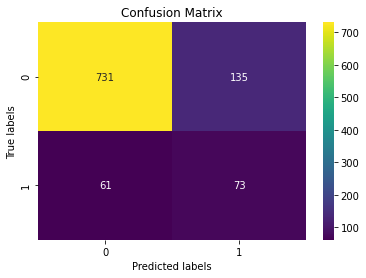

In [36]:
plot_confusion_matrix(task_1_test['tag'], task_1_test['tfidf_prediction'], labels=[0, 1])

In [37]:
display(task_1_test)

,text,tag,tfidf_prediction
0,"@anonymized_account Spoko, jak im Duda z Moraw...",0,0
1,@anonymized_account @anonymized_account Ale on...,0,0
2,@anonymized_account No czy Prezes nie miał rac...,0,0
3,@anonymized_account @anonymized_account Przeci...,0,0
4,@anonymized_account @anonymized_account Owszem...,0,0
...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, p...",0,0
996,@anonymized_account to oczywiste byłyście dziś...,0,0
997,@anonymized_account Duda może się przyjąć w bi...,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła ta...",1,1


#### Task 2

In [38]:
task_2_test_X = pd.DataFrame(
    task_2_tfidf_vectorizer.transform(task_2_test['text']).toarray(),
    columns=task_2_tfidf_vectorizer.get_feature_names()
)

task_2_test['tfidf_prediction'] = task_2_tfidf_classifier.predict(task_2_test_X)

print_metrics(task_2_test['tag'], task_2_test['tfidf_prediction'])

Accuracy: 0.767
F1: 0.7997753058103977
Macro F1: 0.46372375127421
Micro F1: 0.767
MCC: 0.279934378151742


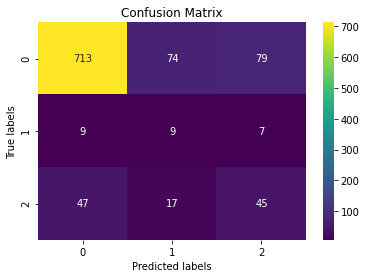

In [39]:
plot_confusion_matrix(task_2_test['tag'], task_2_test['tfidf_prediction'], labels=[0, 1, 2])

In [40]:
display(task_2_test)

,text,tag,tfidf_prediction
0,"@anonymized_account Spoko, jak im Duda z Moraw...",0,0
1,@anonymized_account @anonymized_account Ale on...,0,0
2,@anonymized_account No czy Prezes nie miał rac...,0,0
3,@anonymized_account @anonymized_account Przeci...,0,0
4,@anonymized_account @anonymized_account Owszem...,0,0
...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, p...",0,0
996,@anonymized_account to oczywiste byłyście dziś...,0,2
997,@anonymized_account Duda może się przyjąć w bi...,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła ta...",2,1


### Fasttext text classifier

In [41]:
def fast_text_make_single_prediction(classifier, X):
  prediction = classifier.predict(X)
  prediction = prediction[0][0]
  prediction = prediction.replace('__label__', '')
  prediction = int(prediction)
  return prediction

In [42]:
def fast_text_make_predictions(classifier, Xs):
  predictions = [fast_text_make_single_prediction(classifier, X) for X in Xs]
  return np.array(predictions)

#### Task 1

In [43]:
task_1_test['fast_text_prediction'] = fast_text_make_predictions(
    task_1_fast_text_classifier,
    task_1_test['text']
)

print_metrics(task_1_test['tag'], task_1_test['fast_text_prediction'])

Accuracy: 0.878
F1: 0.8501704757088764
Macro F1: 0.6238236781410722
Micro F1: 0.878
MCC: 0.3163765182804967


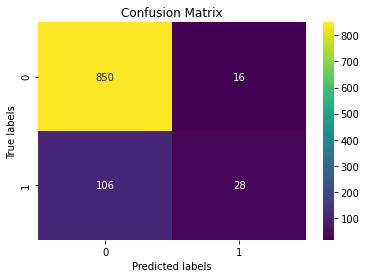

In [44]:
plot_confusion_matrix(task_1_test['tag'], task_1_test['fast_text_prediction'], labels=[0, 1])

In [45]:
display(task_1_test)

,text,tag,tfidf_prediction,fast_text_prediction
0,"@anonymized_account Spoko, jak im Duda z Moraw...",0,0,0
1,@anonymized_account @anonymized_account Ale on...,0,0,0
2,@anonymized_account No czy Prezes nie miał rac...,0,0,0
3,@anonymized_account @anonymized_account Przeci...,0,0,0
4,@anonymized_account @anonymized_account Owszem...,0,0,0
...,...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, p...",0,0,0
996,@anonymized_account to oczywiste byłyście dziś...,0,0,0
997,@anonymized_account Duda może się przyjąć w bi...,0,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła ta...",1,1,0


#### Task 2

In [46]:
task_2_test['fast_text_prediction'] = fast_text_make_predictions(
    task_2_fast_text_classifier,
    task_2_test['text']
)

print_metrics(task_2_test['tag'], task_2_test['fast_text_prediction'])

Accuracy: 0.865
F1: 0.8279785599369602
Macro F1: 0.3985389237285353
Micro F1: 0.865
MCC: 0.20402154468330777


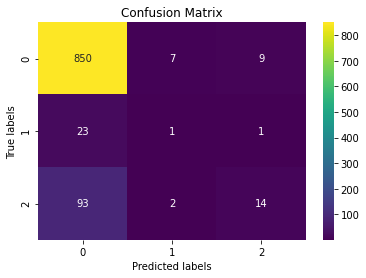

In [47]:
plot_confusion_matrix(task_2_test['tag'], task_2_test['fast_text_prediction'], labels=[0, 1, 2])

In [48]:
display(task_2_test)

,text,tag,tfidf_prediction,fast_text_prediction
0,"@anonymized_account Spoko, jak im Duda z Moraw...",0,0,0
1,@anonymized_account @anonymized_account Ale on...,0,0,0
2,@anonymized_account No czy Prezes nie miał rac...,0,0,0
3,@anonymized_account @anonymized_account Przeci...,0,0,0
4,@anonymized_account @anonymized_account Owszem...,0,0,0
...,...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, p...",0,0,0
996,@anonymized_account to oczywiste byłyście dziś...,0,2,0
997,@anonymized_account Duda może się przyjąć w bi...,0,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła ta...",2,1,0


### Transformer classifier (take into account that a number of experiments should be performed for this model).

#### Task 1

In [64]:
task_1_predictor = ktrain.get_predictor(
    task_1_transformer_learner.model,
    preproc=task_1_transformer
)

task_1_test['transformer_prediction'] =  [
  task_1_predictor.predict(text)
  for text
  in task_1_test['text']
]

print_metrics(task_1_test['tag'], task_1_test['transformer_prediction'])

Accuracy: 0.888
F1: 0.8689337489011428
Macro F1: 0.6803324542475825
Micro F1: 0.888
MCC: 0.4074143351154111


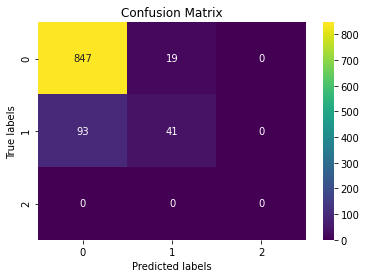

In [69]:
plot_confusion_matrix(task_1_test['tag'], task_1_test['transformer_prediction'], labels=[0, 1])

In [89]:
display(task_1_test)

,text,tag,transformer_prediction,tfidf_prediction,fast_text_prediction
0,"@anonymized_account Spoko, jak im Duda z Moraw...",0,0,0,0
1,@anonymized_account @anonymized_account Ale on...,0,0,0,0
2,@anonymized_account No czy Prezes nie miał rac...,0,0,0,0
3,@anonymized_account @anonymized_account Przeci...,0,0,0,0
4,@anonymized_account @anonymized_account Owszem...,0,0,0,0
...,...,...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, p...",0,0,0,0
996,@anonymized_account to oczywiste byłyście dziś...,0,0,0,0
997,@anonymized_account Duda może się przyjąć w bi...,0,0,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła ta...",1,1,1,0


#### Task 2

Niestety nie udało mi się zrealizować tej części zadania ze względu na zbyt długi czas trwania uczenia.

In [ ]:
task_2_predictor = ktrain.get_predictor(
    task_2_transformer_learner.model,
    preproc=task_2_transformer
)

task_2_test['transformer_prediction'] =  [
  task_2_predictor.predict(text)
  for text
  in task_2_test['text']
]

print_metrics(task_2_test['tag'], task_2_test['transformer_prediction'])

In [ ]:
plot_confusion_matrix(task_2_test['tag'], task_2_test['transformer_prediction'], labels=[0, 1, 2])

In [ ]:
display(task_2_test)

## Select 1 TP, 1 TN, 1 FP and 1 FN from your predictions (for the best classifier) and compare the decisions of each classifier on these examples using SHAP.


Outputy SHAP-a można znaleźć na [Colabie](https://colab.research.google.com/drive/1aXgz0-RsUiFoxjKZG1j9740Y40V2pUk9?usp=sharing).

Wybrane zostały elementy zbioru testowego spełniające zadane warunki dla klasyfikatora transformer, który sprawdził się najlepiej. Niestety porównanie tego klasyfikatora nie zostało uwzględnione w tym punkcie, ze względu na którąś z kolei śmierć kernela.

In [71]:
best_classifier = 'transformer_prediction'

tp = task_1_test[task_1_test['tag'] == 1][task_1_test[best_classifier] == 1]['text'].iloc[:1].values
fp = task_1_test[task_1_test['tag'] == 0][task_1_test[best_classifier] == 1]['text'].iloc[:1].values
tn = task_1_test[task_1_test['tag'] == 0][task_1_test[best_classifier] == 0]['text'].iloc[:1].values
fn = task_1_test[task_1_test['tag'] == 1][task_1_test[best_classifier] == 0]['text'].iloc[:1].values

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


In [75]:
print(f'TP: "{tp[0]}"')
print(f'FP: "{fp[0]}"')
print(f'TN: "{tn[0]}"')
print(f'FN: "{fn[0]}"')

TP: "@anonymized_account Dokładnie, pisdzielstwo nie ma prawa rozpierdalać systemu,  sądownictwa nie mając większości"
FP: "@anonymized_account @anonymized_account Kto mieczem wojuje, ten od pochwy ginie"
TN: "@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok."
FN: "@anonymized_account Tej szmaty się nie komentuje"


#### True positive

> @anonymized_account Dokładnie, pisdzielstwo nie ma prawa rozpierdalać systemu,  sądownictwa nie mając większości

##### Bayesian classifier with TF * IDF weighting.

In [48]:
shap.initjs()

task_1_train_X = pd.DataFrame(
    task_1_tfidf_vectorizer.transform(task_1_train['text']).toarray(),
    columns=task_1_tfidf_vectorizer.get_feature_names()
)

task1_tfidf_explainer = shap.KernelExplainer(
    task_1_tfidf_classifier.predict, 
    task_1_train_X[:25]
)

task_1_tp = pd.DataFrame(
    task_1_tfidf_vectorizer.transform(tp).toarray(),
    columns=task_1_tfidf_vectorizer.get_feature_names()
)

shap_values = task1_tfidf_explainer.shap_values(task_1_tp)
shap.force_plot(task1_tfidf_explainer.expected_value, shap_values, task_1_tp)

##### Fasttext text classifier

In [62]:
shap.initjs()

task1_fast_text_explainer = shap.KernelExplainer(
    lambda Xs: np.array([fast_text_make_single_prediction(task_1_fast_text_classifier, X[0]) for X in Xs]), 
    task_1_train['text'].values.reshape((18380, 1))[:25]
)

shap_values = task1_fast_text_explainer.shap_values(tp)
shap.force_plot(task1_fast_text_explainer.expected_value, shap_values, tp)

#### False positive

> @anonymized_account @anonymized_account Kto mieczem wojuje, ten od pochwy ginie

##### Bayesian classifier with TF * IDF weighting.

In [49]:
shap.initjs()

task_1_fp = pd.DataFrame(
    task_1_tfidf_vectorizer.transform(fp).toarray(),
    columns=task_1_tfidf_vectorizer.get_feature_names()
)

shap_values = task1_tfidf_explainer.shap_values(task_1_fp)
shap.force_plot(task1_tfidf_explainer.expected_value, shap_values, task_1_fp)

##### Fasttext text classifier

In [63]:
shap.initjs()

shap_values = task1_fast_text_explainer.shap_values(fp)
shap.force_plot(task1_fast_text_explainer.expected_value, shap_values, fp)

#### True negative

> @anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.

##### Bayesian classifier with TF * IDF weighting.

In [60]:
shap.initjs()

task_1_tn = pd.DataFrame(
    task_1_tfidf_vectorizer.transform(tn).toarray(),
    columns=task_1_tfidf_vectorizer.get_feature_names()
)

shap_values = task1_tfidf_explainer.shap_values(task_1_tn)
shap.force_plot(task1_tfidf_explainer.expected_value, shap_values, task_1_tn)

##### Fasttext text classifier

In [64]:
shap.initjs()

shap_values = task1_fast_text_explainer.shap_values(tn)
shap.force_plot(task1_fast_text_explainer.expected_value, shap_values, tn)

#### False negative

> @anonymized_account Tej szmaty się nie komentuje

##### Bayesian classifier with TF * IDF weighting.

In [65]:
shap.initjs()

task_1_fn = pd.DataFrame(
    task_1_tfidf_vectorizer.transform(fn).toarray(),
    columns=task_1_tfidf_vectorizer.get_feature_names()
)

shap_values = task1_tfidf_explainer.shap_values(task_1_fn)
shap.force_plot(task1_tfidf_explainer.expected_value, shap_values, task_1_fn)

##### Fasttext text classifier

In [66]:
shap.initjs()

shap_values = task1_fast_text_explainer.shap_values(fn)
shap.force_plot(task1_fast_text_explainer.expected_value, shap_values, fn)

### Task 2

Nie udało mi się niestety zrealizować tego podpunktu dla Taska 2.

## Podsumowanie wyników

W poniższych tabelach przygotowane zostało zestawienie wyników przetestowanych klasyfikatorów w porównaniu z wynikami raportowanymi przez PolEval.

### Task 1

| metoda | accuracy | F1 |
|-|-|-|
|TF-IDF | 81,80 | 83,34 |
|fastText | 87,80 | 84,92 |
|transformer | 88,80 | 86,89 |
|n-waves ULMFiT (PolEval) | 90,10| 58.58 |
|fastText (PolEval) | 87.80 |  41.35 	|

### Task 2

| metoda | micro F1 | macro F1 |
|-|-|-|
|TF-IDF | 76,90 | 46,49 |
|fastText | 86,60 | 40,69 | 
|transformer | ? | ? |
|model1-svm (PolEval) | 87,60 | 51,75 |
|fastText (PolEval) | 86,80 |	47,22	|


## Answer the following questions:

### Which of the classifiers works the best for the task 1 and the task 2.


Według strony PolEval dla zadania pierwszego najistotniejszą metryką jest F1, a w drugiej kolejności accuracy. Idąc tym tropem, dla zadania 1 ranking prezentuje się następująco:
 1. Klasyfikator transformer,
 2. fastText,
 3. TF-IDF.

Wyniki F1 dla TF-IDS i fastText były względnie blisko, ale TF-IDF bardziej odstawało pod względem accuracy.


W zadaniu drugim należy zwrócić największą uwagę na micro i macro F1. Wybór mięszy fastText i TF-IDF jest zatem dosyć trudny, ponieważ każde poradziło sobie lepiej w oczach innej metryki. Przewaga fastText jest jednak na tyle duża w micro F1, że uznałabym go za zwycięzcę w tej kategorii.


### Did you achieve results comparable with the results of [PolEval Task](http://2019.poleval.pl/index.php/results/)?

Porównanie z wynikami PolEval widoczne jest w powyższych tabelach. 

W zadaniu pierwszym udało mi się uzyskać dosyć porównywalny wynik accuracy, jednak wynik metryki F1 wyszedł mi dużo lepszy od wyniku zwycięzcy (nawet w przypadku TF-IDF, czyli najsłabszego klasyfikatora).

W opisie tego zadania na stronie PolEval znalazłam następującą sugestię odnośnie ewaluacji wyników:

> In evaluation one should look primarily at the balanced F-score, with Accuracy as a supporting measure. Furthermore, it is good to keep your scores as close as possible to BEP (break-even-point of Precision and Recall),

zatem przed deklaracją zwycięstwa być może warto by było zerknąć również na precision i recall.

W zadaniu drugim wyniki pokrywają się całkiem nieźle z wynikami PolEval i żadna z metryk wyników nie przekracza rekordowych wartości.

### Did you achieve results comparabie with the [Klej leaderboard](https://klejbenchmark.com/leaderboard/)?

Z [artykułu](https://arxiv.org/pdf/2005.00630.pdf) zalinkowanego na stronie KLEJ-u wywnioskowałam, że zadanie CBD w rankingu to najprawdopodobniej znany nam Task 1, a wartość podanej metryki to F1.

Najwyższy wynik przedstawiony na stronie KLEJ-u to 72,40, co jest wartością znacząco lepszą od wyników raportowanych na stronie PolEval. Tym samym pozornie nadal jest to wynik słabszy od uzyskanego w czasie realizacji zadania, przy czym jak wspomiałam w poprzednim podpunkcie, podchodzę nieco sceptycznie do swoich rezultatów. Wydaje mi się, że porównanie tych rezultatów byłoby łatwiejsze, gdyby przedstawione było więcej metryk takich jak sugerowane przez autorów zadania accuracy, precision i recall.

Ponadto, jeśli dobrze rozumiem, modele przedstawione na stronie KLEJ-u radzą sobie dobrze nie tylko z zadaniem CBD, ale również z wieloma innymi. CBD wydaje się tak naprawdę jedną z ich słabszych stron, zatem porównanie ich z moimi naiwnymi próbami może nie być do końca uczciwe.

### Describe strengths and weaknesses of each of the compared algorithms.
Najłatwiejszy do zrozumienia i implementacji jest klasyfikator bayesowski, jednak równocześnie ma on najsłabsze wyniki. Jest nazywany naiwnym, ponieważ uznaje każdą z cech obiektu za byt niezależny, jednak pomimo tych uproszczeń wcale nie radzi sobie tak źle w praktyce. Od strony technicznej najtrudniejszy w wykorzystaniu był FastText wraz ze swoim specyficznym API, jednak jego działanie okazało się całkiem szybkie, a wyniki zadowalające. Klasyfikator transformer potrzebował zdecydowanie najwięcej czasu na trening (mimo użycia Google Colaboratory z GPU) i kilkukrotnie doprowadził do śmierci kernela i utraty innych wyników. Aby wykorzystać w pełni jego możliwości konieczne byłoby dobranie odpowiednich parametrów (stała ucząca, rozmiar batchy i tak dalej).

### Do you think comparison of raw performance values on a single task is enough to assess the value of a given algorithm/model?
Wydaje mi się, że nie, ale dla specjalisty lub specjalistki być może byłaby to wystarczająca informacja. Sprawę na pewno utrudnia fakt, że dla różnych zadań sugerowane są różne metryki, a ranking bardzo się różni w zależności od wybranego parametru. Dodatkowo, jak można było zauważyć w rankingu KLEJ, różne modele radzą sobie różnie z poszczególnymi zadaniami, więc wynik danego modelu w ramach konkretnego zadania nie musi rzutować na jego ogólną skuteczność.

### Did SHAP show that the models use valuable featurs/words when performing their decision?
W analizie TF-IDS faktycznie można zauważyć, jak poszczególne słowa wyciągają odpowiedź w danym kierunku -- przykładowo "pisdzielstwo", "duda" i "szmata" kierują wynik w stronę mowy nienawiści, a "ok" i "morawiecki" w kierunku przeciwnym. W przypadku FastTextu nie miałam pewności, jak mogę uzyskać analogiczny efekt.